In [1]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.datasets import load_classification
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Kepler Light Curve Dataset

In [2]:
X_train_f, y_train_f = load_classification(name="KeplerLightCurves", split="train", return_metadata=False)
X_test_f, y_test_f = load_classification(name="KeplerLightCurves", split="test", return_metadata=False)

Load in the data...

In [3]:
X_train = X_train_f.squeeze(axis=1)
y_train = y_train_f.astype(int)
X_test = X_test_f.squeeze(axis=1)
y_test = y_test_f.astype(int)

X_train_window = X_train[:, :200]   
X_test_window = X_test[:, :200]

Extract the classes of interest

In [4]:
class_a_tr_idxs = np.argwhere(y_train == 3).flatten()
x_tr_class_a = X_train_window[class_a_tr_idxs, :]
class_b_tr_idxs = np.argwhere(y_train == 5).flatten()
x_tr_class_b = X_train_window[class_b_tr_idxs, :]
X_train_sub = np.vstack([x_tr_class_a, x_tr_class_b])
y_train_sub = np.concatenate([np.ones(len(class_a_tr_idxs), dtype=np.int8), 2*np.ones(len(class_b_tr_idxs), dtype=np.int8)])

In [5]:
class_a_te_idxs = np.argwhere(y_test == 3).flatten()
x_te_class_a = X_test_window[class_a_te_idxs, :]
class_b_te_idxs = np.argwhere(y_test == 5).flatten()
x_te_class_b = X_test_window[class_b_te_idxs, :]
X_test_sub = np.vstack([x_te_class_a, x_te_class_b])
y_test_sub = np.concatenate([np.ones(len(class_a_te_idxs), dtype=np.int8), 2*np.ones(len(class_b_te_idxs), dtype=np.int8)])

Check the shapes

In [6]:
print(X_train_sub.shape)
print(y_train_sub.shape)
print(X_test_sub.shape)
print(y_test_sub.shape)

(427, 200)
(427,)
(185, 200)
(185,)


Z-score the time-series

In [7]:
# rescale the data
zs = StandardScaler().fit(X_train_sub)
X_train_sub_zs = zs.transform(X_train_sub)  
X_test_sub_zs = zs.transform(X_test_sub)

Fit the 1NN-DTW Model

In [214]:
classifier = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier.fit(X_train_sub_zs, y_train_sub)
sc = classifier.score(X_test_sub_zs, y_test_sub)

In [224]:
y_preds = classifier.predict(X_test_sub_zs)
bal_acc = balanced_accuracy_score(y_test_sub, y_preds)

In [225]:
print(f"Raw accuracy: {sc}")
print(f"Balanced accuracy: {bal_acc}")

Raw accuracy: 0.9135135135135135
Balanced accuracy: 0.8980037017451084


In [317]:
confmat = confusion_matrix(y_test_sub, y_preds, normalize='true')
confmat

array([[0.94354839, 0.05645161],
       [0.14754098, 0.85245902]])

In [315]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='1NN-DTW Confusion Matrix, Z-Scored, T = 200',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0.94354839 0.05645161]
 [0.14754098 0.85245902]]


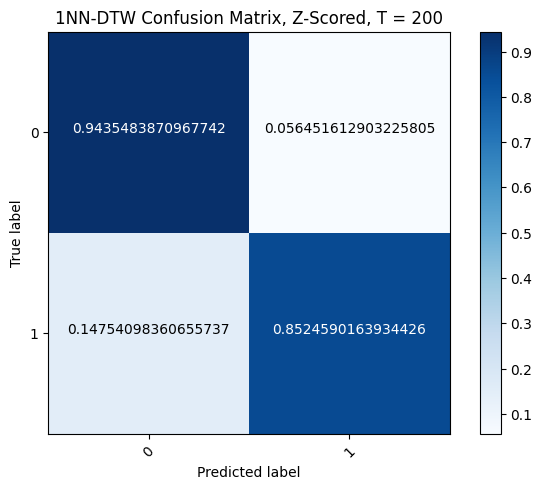

In [318]:
plot_confusion_matrix(confmat, [0, 1])

In [281]:
incorrect_idxs = np.argwhere(y_preds != y_test_sub).flatten()

In [287]:
len(incorrect_idxs)

16

In [280]:
X_test_sub.shape

(185, 200)

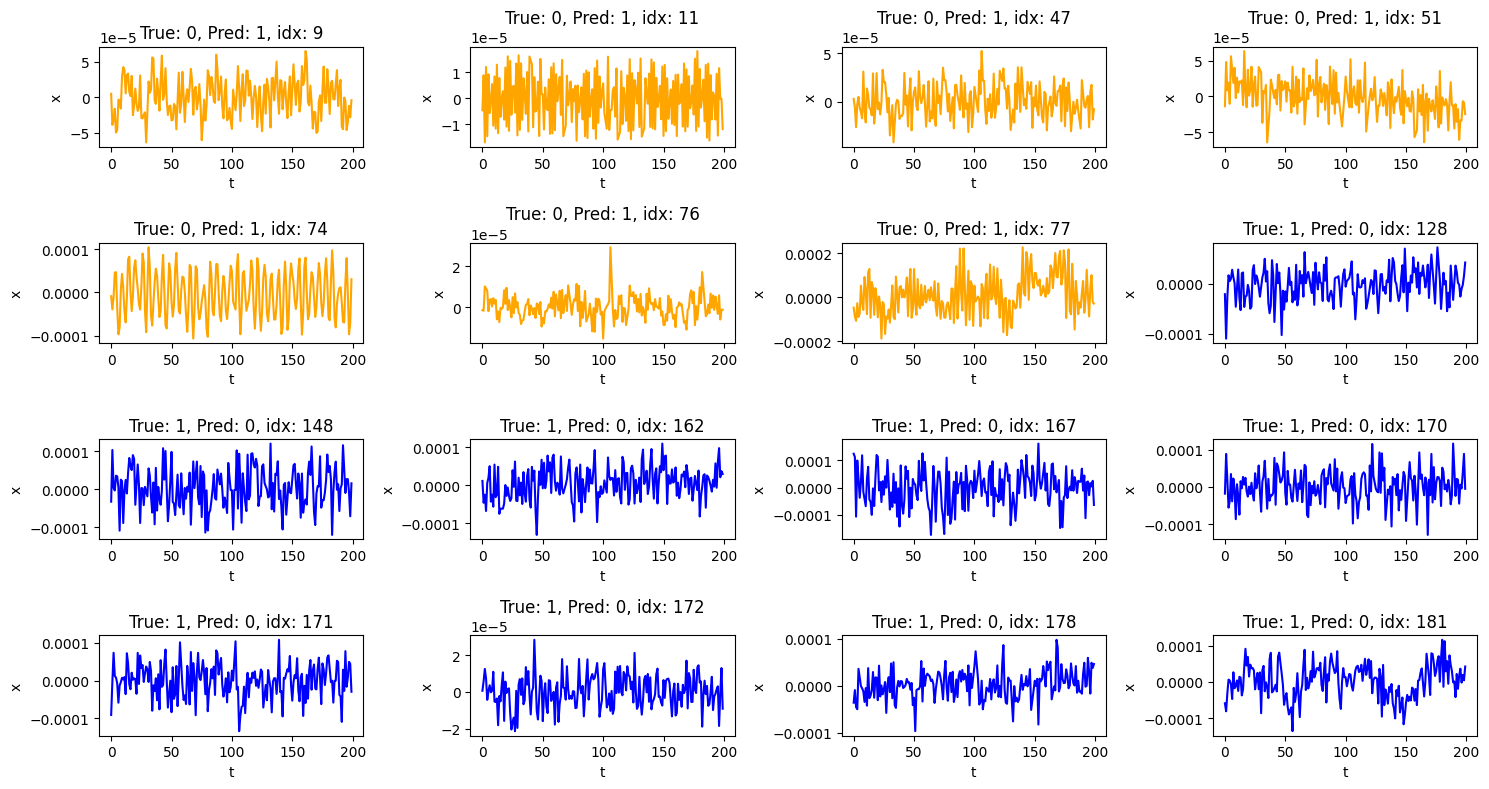

In [309]:
fig, axes = plt.subplots(4, 4, figsize=(15, 8))
for (i, ax) in enumerate(axes.ravel()):
    if y_test_sub[incorrect_idxs[i]] == 1:
        plot_colour = 'orange'
    else:
        plot_colour = 'blue'
    ax.plot(X_test_sub[incorrect_idxs[i]], c=plot_colour)
    ax.set_title(f"True: {y_test_sub[incorrect_idxs[i]]-1}, Pred: {y_preds[incorrect_idxs[i]]-1}, idx: {incorrect_idxs[i]}") # subtract 1 to match julia indexing
    ax.set_xlabel("t")
    ax.set_ylabel("x")
fig.tight_layout()

In [329]:
print(f"precision: {precision_score(y_test_sub, y_preds)}")
print(f"F1: {f1_score(y_test_sub, y_preds)}")
print(f"Recall: {recall_score(y_test_sub, y_preds)}")

precision: 0.9285714285714286
F1: 0.936
Recall: 0.9435483870967742


# MinMax Only

Scaling to the [-1, 1] interval.

In [335]:
# rescale the data
mm = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_sub)
X_train_sub_mm = mm.transform(X_train_sub)  
X_test_sub_mm = mm.transform(X_test_sub)

In [337]:
classifier_mm = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier_mm.fit(X_train_sub_mm, y_train_sub)
sc_mm = classifier.score(X_test_sub_mm, y_test_sub)

In [339]:
sc_mm

0.6702702702702703

In [338]:
y_preds_mm = classifier_mm.predict(X_test_sub_mm)
bal_acc_mm = balanced_accuracy_score(y_test_sub, y_preds_mm)

In [340]:
bal_acc_mm

0.7338709677419355

In [346]:
print(f"precision: {precision_score(y_test_sub, y_preds_mm)}")
print(f"F1: {f1_score(y_test_sub, y_preds_mm)}")
print(f"Recall: {recall_score(y_test_sub, y_preds_mm)}")

precision: 1.0
F1: 0.6373626373626373
Recall: 0.46774193548387094


Confusion matrix, without normalization
[[58 66]
 [ 0 61]]


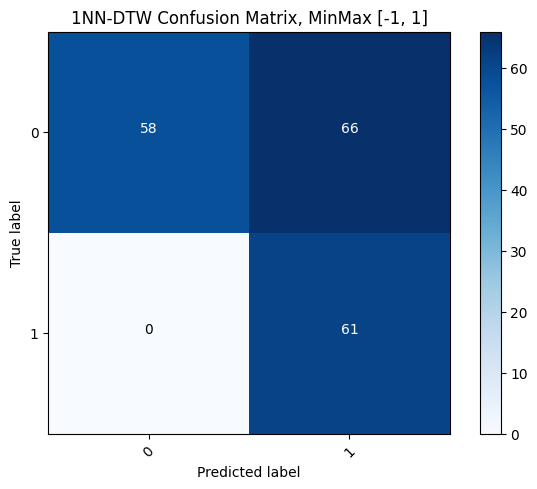

In [345]:
confmat_mm = confusion_matrix(y_test_sub, y_preds_mm)
plot_confusion_matrix(confmat_mm, [0, 1], title="1NN-DTW Confusion Matrix, MinMax [-1, 1]")

# RobustSigmoid Only

In [383]:
from sklearn.base import BaseEstimator, TransformerMixin

In [398]:
class ScaledRobustSigmoid(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        self.medianX = np.median(X)
        self.iqrX = np.quantile(X, 0.75, method='hazen') - np.quantile(X, 0.25, method='hazen')
        return self
    def transform(self, X, y=None, range=(-1, 1)):
        xhat = 1/(1 + np.exp(-(X-self.medianX)/(self.iqrX/1.35)))
        # rescale
        xhat = MinMaxScaler(feature_range=range).fit_transform(xhat)
        return xhat
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [406]:
srs = ScaledRobustSigmoid().fit(X_train_sub)
X_train_sub_srs = srs.transform(X_train_sub)  
X_test_sub_srs = srs.transform(X_test_sub)

In [407]:
classifier_srs = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier_srs.fit(X_train_sub_srs, y_train_sub)
sc_srs = classifier.score(X_test_sub_srs, y_test_sub)

In [408]:
sc_srs

0.8324324324324325

In [409]:
y_preds_srs = classifier_srs.predict(X_test_sub_srs)
bal_acc_srs = balanced_accuracy_score(y_test_sub, y_preds_srs)
bal_acc_srs

0.8445267054468535

In [410]:
print(f"precision: {precision_score(y_test_sub, y_preds_srs)}")
print(f"F1: {f1_score(y_test_sub, y_preds_srs)}")
print(f"Recall: {recall_score(y_test_sub, y_preds_srs)}")

precision: 0.8759124087591241
F1: 0.9195402298850575
Recall: 0.967741935483871


Confusion matrix, without normalization
[[0.96774194 0.03225806]
 [0.27868852 0.72131148]]


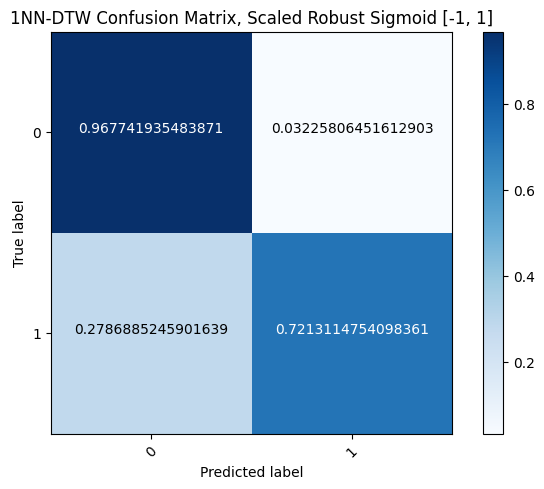

In [413]:
confmat_srs = confusion_matrix(y_test_sub, y_preds_srs, normalize='true')
plot_confusion_matrix(confmat_srs, [0, 1], title="1NN-DTW Confusion Matrix, Scaled Robust Sigmoid [-1, 1]")

# 30-Fold Acc Benchmarking

Import fold idxs from Julia. Correct for one-indexing.

In [8]:
import ast

In [9]:
df = pd.read_csv("/Users/joshua/Desktop/QuantumInspiredML/FinalBenchmarks/Kepler/KeplerSplitIdxsJulia.csv")
data = list(df.itertuples(index=False, name=None))

Combine train and test into Xs and ys

In [10]:
Xs = np.vstack([X_train_sub_zs, X_test_sub_zs])
ys = np.concatenate([y_train_sub, y_test_sub])

In [11]:
data

[('[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [14]:
np.random.seed(42)

In [16]:
per_fold_accs = []
per_fold_bal_accs = []
for i in range(0, len(data)):
    print(f"Evaluating on fold {i}/{len(data)-1}")
    fold_train_idxs = np.array((ast.literal_eval(data[i][0]))) - 1 # subtract one for zero indexing
    fold_test_idxs = np.array((ast.literal_eval(data[i][1]))) - 1
    X_train_fold, X_test_fold = Xs[fold_train_idxs, :], Xs[fold_test_idxs, :]
    y_train_fold, y_test_fold = ys[fold_train_idxs], ys[fold_test_idxs]
    classifier = KNeighborsTimeSeriesClassifier(distance="dtw")
    classifier.fit(X_train_fold, y_train_fold)
    sc = classifier.score(X_test_fold, y_test_fold)
    y_preds = classifier.predict(X_test_fold)
    bal_acc = balanced_accuracy_score(y_test_fold, y_preds)
    per_fold_accs.append(sc)
    per_fold_bal_accs.append(bal_acc)
    print(f"Fold {i} done - Acc: {sc} | Bal Ac.: {bal_acc}")

Evaluating on fold 0/29
Fold 0 done - Acc: 0.9135135135135135 | Bal Ac.: 0.8980037017451084
Evaluating on fold 1/29
Fold 1 done - Acc: 0.8810810810810811 | Bal Ac.: 0.8529878371232151
Evaluating on fold 2/29
Fold 2 done - Acc: 0.9027027027027027 | Bal Ac.: 0.8857747223691168
Evaluating on fold 3/29
Fold 3 done - Acc: 0.8972972972972973 | Bal Ac.: 0.8609201480698043
Evaluating on fold 4/29
Fold 4 done - Acc: 0.8918918918918919 | Bal Ac.: 0.869381279746166
Evaluating on fold 5/29
Fold 5 done - Acc: 0.8972972972972973 | Bal Ac.: 0.8942358540454786
Evaluating on fold 6/29
Fold 6 done - Acc: 0.8810810810810811 | Bal Ac.: 0.8696456901110523
Evaluating on fold 7/29
Fold 7 done - Acc: 0.9135135135135135 | Bal Ac.: 0.9063326282390269
Evaluating on fold 8/29
Fold 8 done - Acc: 0.9081081081081082 | Bal Ac.: 0.8939714436805922
Evaluating on fold 9/29
Fold 9 done - Acc: 0.8864864864864865 | Bal Ac.: 0.8695134849286092
Evaluating on fold 10/29
Fold 10 done - Acc: 0.8972972972972973 | Bal Ac.: 0.8859

In [17]:
mean_acc = np.mean(per_fold_accs)
standard_error_acc = np.std(per_fold_accs)/np.sqrt(len(data))
mean_bal_acc = np.mean(per_fold_bal_accs)
standard_error_bal_acc = np.std(per_fold_bal_accs)/np.sqrt(len(data))
print(f"Mean acc: {mean_acc} | Standard Error: {standard_error_acc}")
print(f"Mean bal. acc: {mean_bal_acc} | Standard Error Bal. Acc: {standard_error_bal_acc}")


Mean acc: 0.8971171171171172 | Standard Error: 0.0023559319345314305
Mean bal. acc: 0.8756389917151419 | Standard Error Bal. Acc: 0.0031426471355899873


In [18]:
save_data = np.vstack([per_fold_accs, per_fold_bal_accs])
df = pd.DataFrame(save_data, columns=[f'fold {i}' for i in range(len(data))])
df.index = ['per_fold_accs', 'per_fold_bal_accs']
df.to_csv("Kepler_1NN_Bench.csv")

In [19]:
df

,fold 0,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,...,fold 20,fold 21,fold 22,fold 23,fold 24,fold 25,fold 26,fold 27,fold 28,fold 29
per_fold_accs,0.913514,0.881081,0.902703,0.897297,0.891892,0.897297,0.881081,0.913514,0.908108,0.886486,...,0.886486,0.886486,0.881081,0.908108,0.924324,0.913514,0.897297,0.924324,0.886486,0.881081
per_fold_bal_accs,0.898004,0.852988,0.885775,0.860920,0.869381,0.894236,0.869646,0.906333,0.893971,0.869513,...,0.869513,0.852856,0.844659,0.885643,0.906068,0.885510,0.881742,0.901904,0.865349,0.852988
